In [1]:
# # ETAPA 1: Importação e Leitura
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt

# Ler o arquivo
arquivo = 'BASE_IND_DOL_HISTORICO (1).xlsx'
#df = pd.read_excel(arquivo)
df = pd.read_excel(arquivo)


colunas_numericas = ['Abertura', 'Máxima', 'Mínima', 'Fechamento', 'VWAP S', 'Prior Cote Ajuste',
                     'Volume Acumulado de Agressão', 'Negócios Acumulados de Agressão'
                     ]

for col in colunas_numericas:
    df[col] = (df[col]
                 .astype(str)
                 .str.replace('.', '', regex=False)
                 .str.replace(',', '.', regex=False))

    df[col] = pd.to_numeric(df[col], errors='coerce')  # ← transforma em número, erros viram NaN

# Ajustar datas
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Filtrar ativos
ativos_validos = ['DOLFUT', 'WDOFUT', 'INDFUT', 'WINFUT']
df = df[df['ATIVO'].isin(ativos_validos)].copy()

# # ETAPA 3: Cálculo de Agressão Forte
# Simulando Volume Total como proxy
# (Aqui você pode mudar para seu Volume Real)
df['Volume Total'] = df['Volume Acumulado de Agressão'].abs() * 2

df['Pct_Agressao'] = (df['Volume Acumulado de Agressão'].abs() / df['Volume Total']) * 100

limite_pct = 5  # Limite 5%
df['Agressao_Forte'] = (df['Pct_Agressao'] >= limite_pct).astype(int)

# # ETAPA 4: Estocástico

# Ordenar para evitar bugs
df = df.sort_values(['ATIVO', 'Data'])

def calcula_estocastico(grupo):
    so = ta.momentum.StochasticOscillator(
        high=grupo['Máxima'],
        low=grupo['Mínima'],
        close=grupo['Fechamento'],
        window=14,
        smooth_window=3
    )
    grupo['stoch_k'] = so.stoch()
    grupo['stoch_d'] = so.stoch_signal()
    return grupo

df = df.groupby('ATIVO').apply(calcula_estocastico)

# Flags de Sobrecomprado/Sobrevendido
df['Sobrecomprado'] = (df['stoch_k'] > 70).astype(int)
df['Sobrevendido'] = (df['stoch_k'] < 30).astype(int)

# # ETAPA 5: Correlação dos Pares

# Pivotar agressão por data e ativo
pivot_agg = df.pivot(index='Data', columns='ATIVO', values='Volume Acumulado de Agressão')

# Correlação rolling
pivot_agg['Corr_DOL_WDO'] = pivot_agg['DOLFUT'].rolling(5).corr(pivot_agg['INDFUT'])
pivot_agg['Corr_IND_WIN'] = pivot_agg['INDFUT'].rolling(5).corr(pivot_agg['DOLFUT'])

# Merge de volta para df
df = df.merge(pivot_agg[['Corr_DOL_WDO', 'Corr_IND_WIN']], on='Data', how='left')

# # ETAPA 6: Sinal Final

# Cria sinal de compra/venda

def gerar_sinal(row):
    if row['ATIVO'] in ['INDFUT', 'WDOFUT']:
        corr = row['Corr_DOL_WDO']
    else:
        corr = row['Corr_IND_WIN']

    if (
        row['Volume Acumulado de Agressão'] > 0 and
        row['Agressao_Forte'] == 1 and
        row['Sobrecomprado'] == 0 and
        corr > 0.8
    ):
        return 'Compra'

    if (
        row['Volume Acumulado de Agressão'] < 0 and
        row['Agressao_Forte'] == 1 and
        row['Sobrevendido'] == 0 and
        corr > 0.8
    ):
        return 'Venda'

    return 'Neutro'

df['Sinal_Final'] = df.apply(gerar_sinal, axis=1)

# # ETAPA 7: Visualizar

# Mostrar apenas quando há sinal
sinais = df[df['Sinal_Final'] != 'Neutro'][['Data', 'ATIVO', 'Sinal_Final']]
print(sinais)




C:\Users\leonardo.fernandes\AppData\Local\Temp\ipykernel_26240\636888182.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ATIVO').apply(calcula_estocastico)


            Data   ATIVO Sinal_Final
3009  2015-03-04  DOLFUT       Venda
3100  2015-07-16  DOLFUT       Venda
3205  2015-12-16  DOLFUT       Venda
3244  2016-02-18  DOLFUT      Compra
3245  2016-02-19  DOLFUT       Venda
...          ...     ...         ...
20737 2024-07-23  WINFUT       Venda
20767 2024-09-03  WINFUT       Venda
20783 2024-09-25  WINFUT       Venda
20784 2024-09-26  WINFUT       Venda
20918 2025-04-14  WINFUT       Venda

[147 rows x 3 columns]


In [2]:
df

,ATIVO,Data,Abertura,Máxima,Mínima,Fechamento,VWAP S,Prior Cote Ajuste,Volume Acumulado de Agressão,Negócios Acumulados de Agressão,Volume Total,Pct_Agressao,Agressao_Forte,stoch_k,stoch_d,Sobrecomprado,Sobrevendido,Corr_DOL_WDO,Corr_IND_WIN,Sinal_Final
0,DOLFUT,2003-01-02,2252731,2278476,2233422,2269466,1796,NaN,0,0,0,NaN,0,NaN,NaN,0,0,NaN,NaN,Neutro
1,DOLFUT,2003-01-03,2268822,2268822,2202527,2208963,1783,NaN,0,0,0,NaN,0,NaN,NaN,0,0,NaN,NaN,Neutro
2,DOLFUT,2003-01-06,2204458,2206389,2147175,2158117,173,0.0,0,0,0,NaN,0,NaN,NaN,0,0,NaN,NaN,Neutro
3,DOLFUT,2003-01-07,2149749,2181287,2124003,2127222,1723,0.0,0,0,0,NaN,0,NaN,NaN,0,0,NaN,NaN,Neutro
4,DOLFUT,2003-01-08,213044,2153611,2105338,2145244,1716,0.0,0,0,0,NaN,0,NaN,NaN,0,0,NaN,NaN,Neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20921,WINFUT,2025-04-17,1308550,1326000,1302700,1318750,13152608,1278500.0,8883788210,-16557,17767576420,50.0,1,0.130637,0.006438,0,1,0.391609,0.391609,Neutro
20922,WINFUT,2025-04-22,1321400,1333350,1309400,1331100,13229629,1319840.0,22363222180,12692,44726444360,50.0,1,0.231158,0.125737,0,1,0.448159,0.448159,Neutro
20923,WINFUT,2025-04-23,1341250,1357700,1341100,1350150,1336683,1319840.0,-18175761770,-24182,36351523540,50.0,1,0.386213,0.249336,0,1,0.419314,0.419314,Neutro
20924,WINFUT,2025-04-24,1347850,1373900,1346750,1370500,13445134,1319840.0,32153623010,-3723,64307246020,50.0,1,0.553133,0.390168,0,1,0.154672,0.154672,Neutro


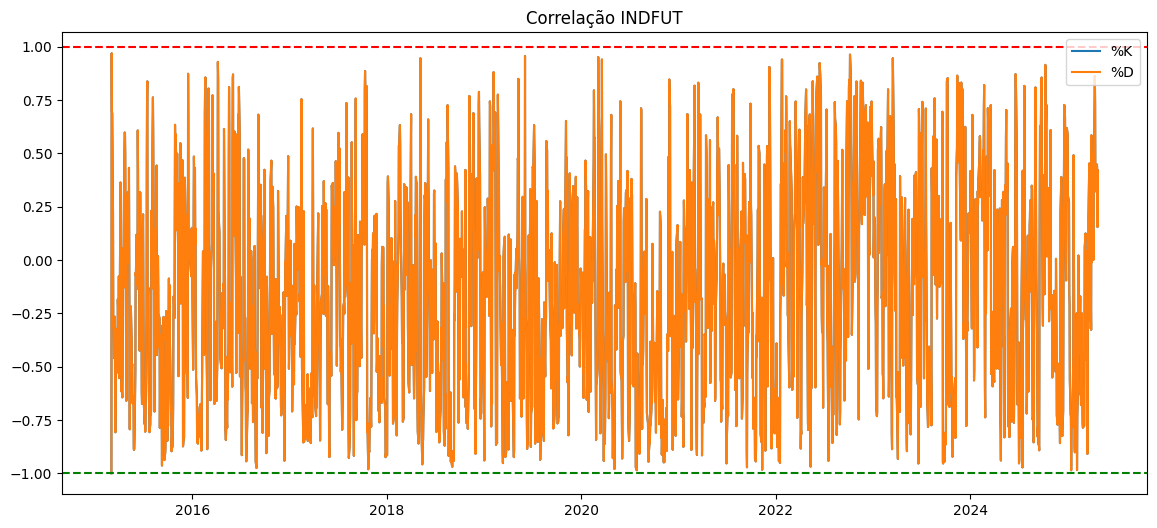

In [3]:
# (Opcional) Plotar estocástico de um ativo
ativo_plot = 'INDFUT'
df_plot = df[df['ATIVO'] == ativo_plot]

plt.figure(figsize=(14,6))
plt.plot(df_plot['Data'], df_plot['Corr_DOL_WDO'], label='%K')
plt.plot(df_plot['Data'], df_plot['Corr_IND_WIN'], label='%D')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.title(f'Correlação {ativo_plot}')
plt.legend()
plt.show()

In [4]:
# Ordenar primeiro
df = df.sort_values(['ATIVO', 'Data'])

# Calcular o desvio padrão móvel de 10 dias
df['Desvio_Padrao_10d'] = df.groupby('ATIVO')['Fechamento'].transform(lambda x: x.rolling(window=10).std())

# (Opcional) Desvio relativo em %
df['Desvio_Relativo'] = (df['Desvio_Padrao_10d'] / df['Fechamento']) * 100


In [5]:
df

,ATIVO,Data,Abertura,Máxima,Mínima,Fechamento,VWAP S,Prior Cote Ajuste,Volume Acumulado de Agressão,Negócios Acumulados de Agressão,...,Agressao_Forte,stoch_k,stoch_d,Sobrecomprado,Sobrevendido,Corr_DOL_WDO,Corr_IND_WIN,Sinal_Final,Desvio_Padrao_10d,Desvio_Relativo
0,DOLFUT,2003-01-02,2252731,2278476,2233422,2269466,1796,NaN,0,0,...,0,NaN,NaN,0,0,NaN,NaN,Neutro,NaN,NaN
1,DOLFUT,2003-01-03,2268822,2268822,2202527,2208963,1783,NaN,0,0,...,0,NaN,NaN,0,0,NaN,NaN,Neutro,NaN,NaN
2,DOLFUT,2003-01-06,2204458,2206389,2147175,2158117,173,0.0,0,0,...,0,NaN,NaN,0,0,NaN,NaN,Neutro,NaN,NaN
3,DOLFUT,2003-01-07,2149749,2181287,2124003,2127222,1723,0.0,0,0,...,0,NaN,NaN,0,0,NaN,NaN,Neutro,NaN,NaN
4,DOLFUT,2003-01-08,213044,2153611,2105338,2145244,1716,0.0,0,0,...,0,NaN,NaN,0,0,NaN,NaN,Neutro,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20921,WINFUT,2025-04-17,1308550,1326000,1302700,1318750,13152608,1278500.0,8883788210,-16557,...,1,0.130637,0.006438,0,1,0.391609,0.391609,Neutro,5.616022e+06,425.859489
20922,WINFUT,2025-04-22,1321400,1333350,1309400,1331100,13229629,1319840.0,22363222180,12692,...,1,0.231158,0.125737,0,1,0.448159,0.448159,Neutro,5.995579e+06,450.422914
20923,WINFUT,2025-04-23,1341250,1357700,1341100,1350150,1336683,1319840.0,-18175761770,-24182,...,1,0.386213,0.249336,0,1,0.419314,0.419314,Neutro,6.126453e+06,453.760882
20924,WINFUT,2025-04-24,1347850,1373900,1346750,1370500,13445134,1319840.0,32153623010,-3723,...,1,0.553133,0.390168,0,1,0.154672,0.154672,Neutro,6.038363e+06,440.595655


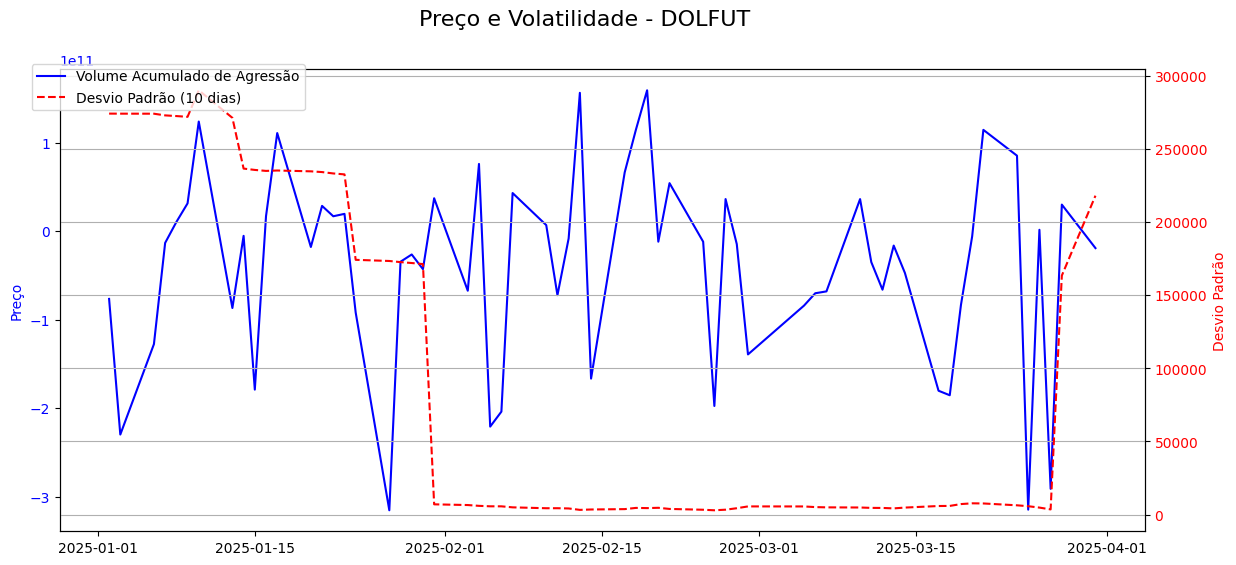

In [30]:
import matplotlib.pyplot as plt

# Ativo que você quer visualizar
ativo_plot = 'DOLFUT'

# Filtrar o ativo
#df_plot = df[df['ATIVO'] == ativo_plot and df['DATA'] >= '2025-01-01']

df_plot = df[
    (df['ATIVO'] == ativo_plot) &
    (df['Data'] >= '2025-01-01') &
    (df['Data'] <= '2025-03-31')
]


# Criar a figura e o eixo
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plotar Fechamento
ax1.plot(df_plot['Data'], df_plot['Volume Acumulado de Agressão'], color='blue', label='Volume Acumulado de Agressão')
ax1.set_ylabel('Preço', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Eixo secundário para o Desvio Padrão
ax2 = ax1.twinx()
ax2.plot(df_plot['Data'], df_plot['Desvio_Padrao_10d'], color='red', label='Desvio Padrão (10 dias)', linestyle='--')
ax2.set_ylabel('Desvio Padrão', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Títulos e legendas
fig.suptitle(f'Preço e Volatilidade - {ativo_plot}', fontsize=16)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.grid(True)
plt.show()


In [7]:
limite_vol = df_plot['Desvio_Padrao_10d'].mean()  # exemplo: média histórica do desvio

ax2.axhline(limite_vol, color='purple', linestyle=':', label='Média Desvio Padrão')


In [8]:
# Para cada ativo, calcular a média do desvio
media_desvio = df.groupby('ATIVO')['Desvio_Padrao_10d'].transform('mean')


In [9]:
# Flag de volatilidade alta
df['Volatilidade_Alta'] = (df['Desvio_Padrao_10d'] > media_desvio).astype(int)


In [10]:
# Retorno percentual diário
df['Retorno'] = df.groupby('ATIVO')['Fechamento'].pct_change()


In [11]:
# Somente onde sinal != neutro
entradas = df[df['Sinal_Final'].isin(['Compra', 'Venda'])].copy()


In [16]:
# Shift para pegar o retorno do próximo dia
entradas['Retorno_Prox'] = entradas.groupby('ATIVO')['Retorno'].shift(-1)

# Resultado baseado no sinal
def resultado(row):
    if row['Sinal_Final'] == 'Compra':
        return -row['Retorno_Prox']
    elif row['Sinal_Final'] == 'Venda':
        return row['Retorno_Prox']
    else:
        return 0

entradas['Resultado_Trade'] = entradas.apply(resultado, axis=1)


In [22]:
# Total de trades
total_trades = entradas.shape[0]

# Trades vencedores
vencedores = entradas[entradas['Resultado_Trade'] > 0].shape[0]

# % de acerto
pct_acerto = (vencedores / total_trades) * 100

# Lucro total
lucro_total = entradas['Resultado_Trade'].sum()

print(f'Total de Trades: {total_trades}')
print(f'Percentual de Acerto: {pct_acerto:.2f}%')
print(f'Lucro Total: {lucro_total:.4f} ({lucro_total*100:.2f}%)')


Total de Trades: 147
Percentual de Acerto: 39.46%
Lucro Total: 48.8180 (4881.80%)


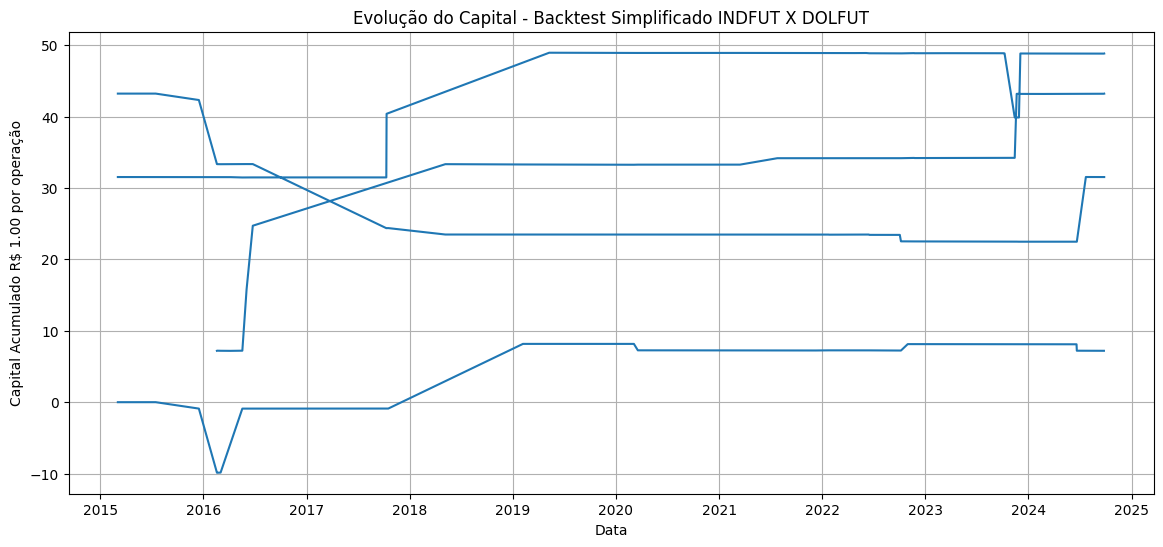

In [25]:
entradas['Capital'] = entradas['Resultado_Trade'].cumsum()

plt.figure(figsize=(14,6))
plt.plot(entradas['Data'], entradas['Capital'])
plt.title('Evolução do Capital - Backtest Simplificado INDFUT X DOLFUT')
plt.xlabel('Data')
plt.ylabel('Capital Acumulado R$ 1.00 por operação')
plt.grid(True)
plt.show()


LAF ROBOZITO V12
28/04/2025

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ler as abas
arquivo = 'OPERACOES_TRADE_TCC_202501_202503_GERAL.xlsx'
df_real = pd.read_excel(arquivo, sheet_name='OPERACOES_TRADE_TCC_2025_REAL',skiprows=5)
df_simula = pd.read_excel(arquivo, sheet_name='OPERACOES_TRADE_TCC_2025_SIMULA',skiprows=5)


In [42]:
df_simula.count()

ESTRATEGIA            9025
Ativo                 9025
Abertura              9025
Fechamento            9025
Tempo Operação        9025
Qtd Compra            9025
Qtd Venda             9025
Lado                  9025
Preço Compra          9025
Preço Venda           9025
Preço de Mercado      9025
MEP                   9025
MEN                   9025
Ag. Compra            9025
Ag. Venda             9025
Médio                 9025
Res. Intervalo        9025
Res. Intervalo (%)    9025
Número Operação       9025
Res. Operação         9025
Res. Operação (%)     9025
TET                   9025
Total                 9025
dtype: int64

In [40]:
df_real.count()

Ativo                 796
Abertura              796
Fechamento            796
Tempo Operação        796
Qtd Compra            796
Qtd Venda             796
Lado                  796
Preço Compra          796
Preço Venda           796
Preço de Mercado      796
MEP                   796
MEN                   796
Ag. Compra            796
Ag. Venda             796
Médio                 796
Res. Intervalo        796
Res. Intervalo (%)    796
Número Operação       796
Res. Operação         796
Res. Operação (%)     796
TET                   796
Total                 796
dtype: int64

In [41]:
df_simula.count()

ESTRATEGIA            9025
Ativo                 9025
Abertura              9025
Fechamento            9025
Tempo Operação        9025
Qtd Compra            9025
Qtd Venda             9025
Lado                  9025
Preço Compra          9025
Preço Venda           9025
Preço de Mercado      9025
MEP                   9025
MEN                   9025
Ag. Compra            9025
Ag. Venda             9025
Médio                 9025
Res. Intervalo        9025
Res. Intervalo (%)    9025
Número Operação       9025
Res. Operação         9025
Res. Operação (%)     9025
TET                   9025
Total                 9025
dtype: int64

In [58]:
def resumo_operacoes(df, nome):
    print(f"\nResumo: {nome}")
    total_operacoes = len(df)
    taxa_acerto = (df['Res. Operação'] > 0).sum() /total_operacoes
    ganho_acumulado = df['Res. Operação'].sum()
    media_ganho = df['Res. Operação'].mean()
    melhor_op = df.loc[df['Res. Operação'].idxmax()]
    pior_op = df.loc[df['Res. Operação'].idxmin()]

    print(f"Total de Operações: {total_operacoes}")
    print(f"Taxa de Acerto: {taxa_acerto:.2f}%")
    print(f"Ganho Acumulado: R$ {ganho_acumulado:.2f}")
    print(f"Média de Ganho por Operação: R$ {media_ganho:.2f}")
    print(f"Melhor Operação: R$ {melhor_op['Res. Operação']} em {melhor_op['Fechamento']}")
    print(f"Pior Operação: R$ {pior_op['Res. Operação']} em {pior_op['Fechamento']}")
    
    return {
        'total': total_operacoes,
        'acerto': taxa_acerto,
        'ganho': ganho_acumulado,
        'media': media_ganho,
        'melhor': melhor_op,
        'pior': pior_op
    }


In [63]:
resumo_simu = resumo_operacoes(df_simula, 'Conta Simuladora')



Resumo: Conta Simuladora
Total de Operações: 9025
Taxa de Acerto: 0.79%
Ganho Acumulado: R$ 73752.00
Média de Ganho por Operação: R$ 8.17
Melhor Operação: R$ 5296 em 2025-02-07 15:58:13
Pior Operação: R$ -2840 em 2025-03-06 16:05:20


In [70]:
resumo_real = resumo_operacoes(df_real, 'Conta Real')


Resumo: Conta Real
Total de Operações: 796
Taxa de Acerto: 0.75%
Ganho Acumulado: R$ 3139.00
Média de Ganho por Operação: R$ 3.94
Melhor Operação: R$ 609 em 2025-03-27 10:10:06
Pior Operação: R$ -598 em 2025-01-23 14:50:08


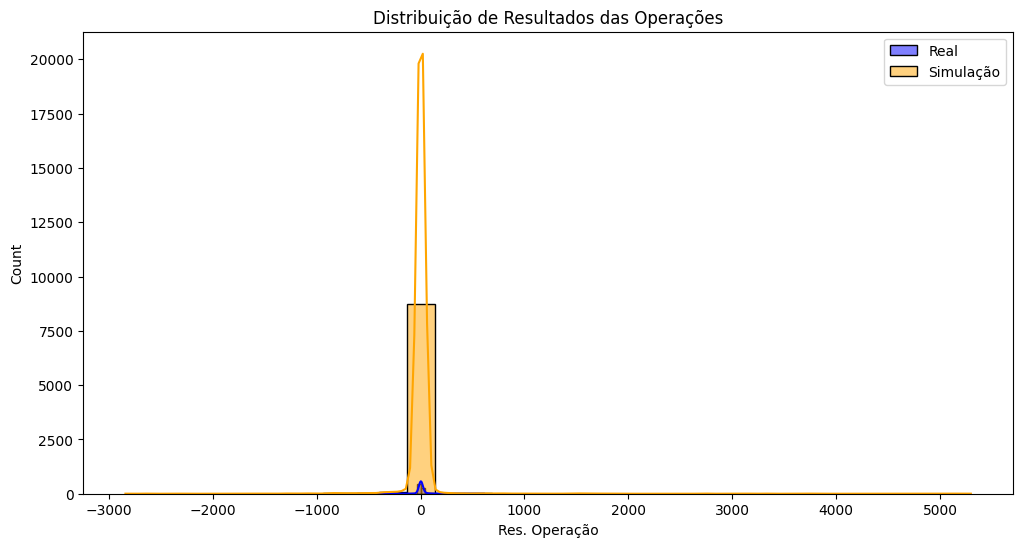

In [61]:
plt.figure(figsize=(12,6))
sns.histplot(df_real['Res. Operação'], bins=30, color='blue', label='Real', kde=True)
sns.histplot(df_simula['Res. Operação'], bins=30, color='orange', label='Simulação', kde=True)
plt.title('Distribuição de Resultados das Operações')
plt.legend()
plt.show()


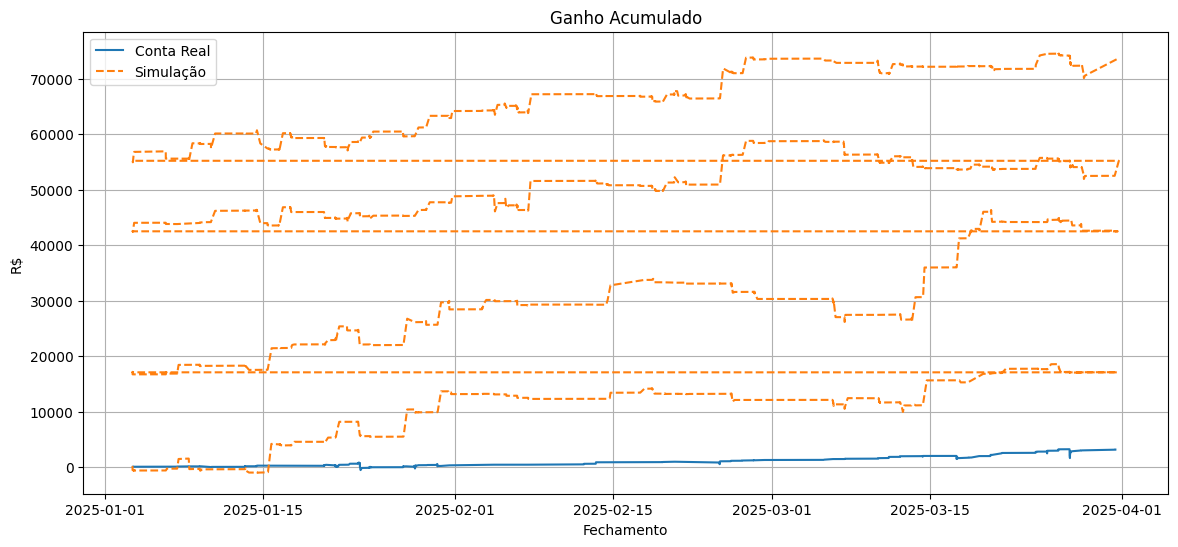

In [69]:
df_real['Ganho Acumulado'] = df_real['Res. Operação'].cumsum()
df_simula['Ganho Acumulado'] = df_simula['Res. Operação'].cumsum()

plt.figure(figsize=(14,6))
plt.plot(df_real['Fechamento'], df_real['Ganho Acumulado'], label='Conta Real')
plt.plot(df_simula['Fechamento'], df_simula['Ganho Acumulado'], label='Simulação', linestyle='--')
plt.title('Ganho Acumulado')
plt.xlabel('Fechamento')
plt.ylabel('R$')
plt.legend()
plt.grid(True)
plt.show()


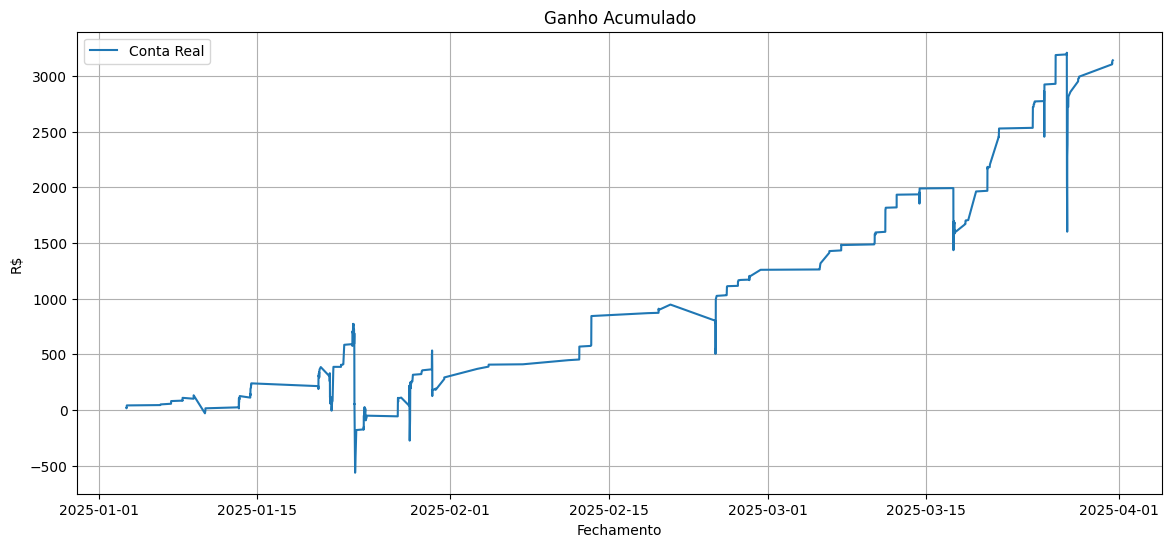

In [71]:
df_real['Ganho Acumulado'] = df_real['Res. Operação'].cumsum()

plt.figure(figsize=(14,6))
plt.plot(df_real['Fechamento'], df_real['Ganho Acumulado'], label='Conta Real')
plt.title('Ganho Acumulado')
plt.xlabel('Fechamento')
plt.ylabel('R$')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
print("Operações Reais:", len(df_real))
print("Operações Simuladas:", len(df_simula))


Operações Reais: 796
Operações Simuladas: 9025


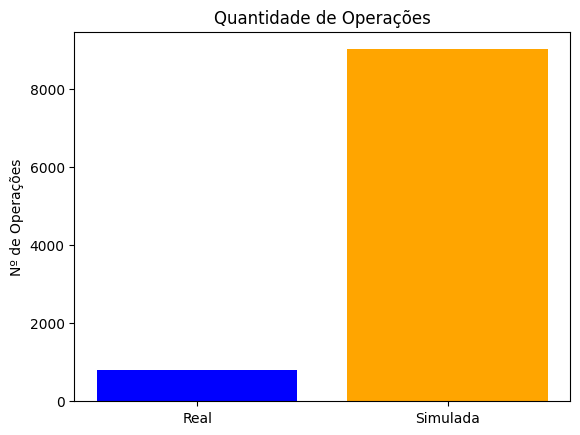

In [73]:
import matplotlib.pyplot as plt

plt.bar(['Real', 'Simulada'], [len(df_real), len(df_simula)], color=['blue', 'orange'])
plt.title('Quantidade de Operações')
plt.ylabel('Nº de Operações')
plt.show()


In [75]:
df_real['duracao'] = (df_real['Fechamento'] - df_real['Abertura']).dt.total_seconds() / 60  # em minutos
df_simula['duracao'] = (df_simula['Fechamento'] - df_simula['Abertura']).dt.total_seconds() / 60

print("Tempo médio - Real:", df_real['duracao'].mean(), "minutos")
print("Tempo médio - Simulada:", df_simula['duracao'].mean(), "minutos")


Tempo médio - Real: 2.1095268006700167 minutos
Tempo médio - Simulada: 5.084565096952908 minutos


C:\Users\leonardo.fernandes\AppData\Local\Temp\ipykernel_26240\1571854289.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_real['duracao'], df_simula['duracao']], labels=['Real', 'Simulada'])


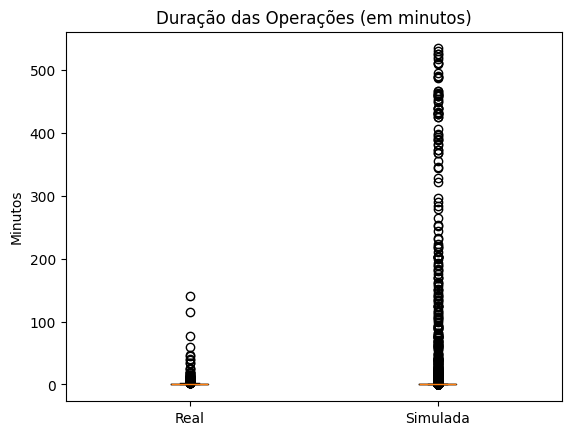

In [76]:
plt.boxplot([df_real['duracao'], df_simula['duracao']], labels=['Real', 'Simulada'])
plt.title('Duração das Operações (em minutos)')
plt.ylabel('Minutos')
plt.show()


In [78]:
print("Ganho Médio Real:", df_real['Res. Operação'].mean())
print("Ganho Médio Simulado:", df_simula['Res. Operação'].mean())


Ganho Médio Real: 3.943467336683417
Ganho Médio Simulado: 8.17196675900277


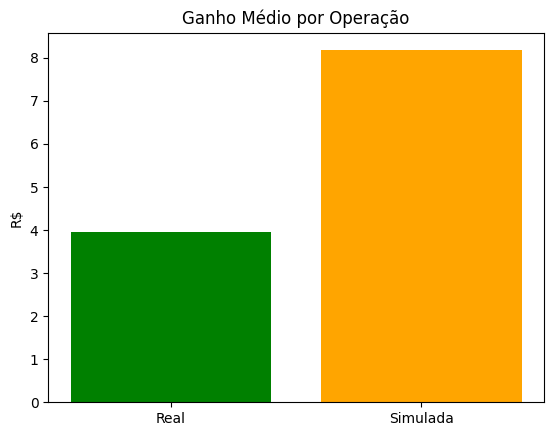

In [79]:
plt.bar(['Real', 'Simulada'], [df_real['Res. Operação'].mean(), df_simula['Res. Operação'].mean()], color=['green', 'orange'])
plt.title('Ganho Médio por Operação')
plt.ylabel('R$')
plt.show()


In [81]:
df_real['hora_abertura'] = df_real['Abertura'].dt.hour
df_simula['hora_abertura'] = df_simula['Abertura'].dt.hour


In [85]:
def classifica_turno(hora):
    if 9 <= hora < 10:
        return 'Manhã'
    elif 12 <= hora <= 18:
        return 'Tarde'
    else:
        return 'Fora do Horário'

df_real['turno'] = df_real['hora_abertura'].apply(classifica_turno)
df_simula['turno'] = df_simula['hora_abertura'].apply(classifica_turno)


In [86]:
print("REAL:\n", df_real['turno'].value_counts())
print("\nSIMULADA:\n", df_simula['turno'].value_counts())


REAL:
 turno
Manhã              415
Fora do Horário    246
Tarde              135
Name: count, dtype: int64

SIMULADA:
 turno
Tarde              3460
Fora do Horário    3215
Manhã              2350
Name: count, dtype: int64


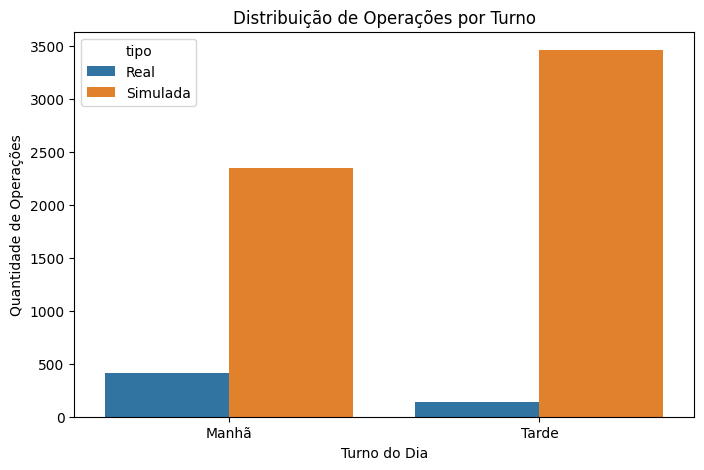

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

df_real['tipo'] = 'Real'
df_simula['tipo'] = 'Simulada'

df_comparativo = pd.concat([df_real, df_simula])

plt.figure(figsize=(8,5))
sns.countplot(data=df_comparativo[df_comparativo['turno'] != 'Fora do Horário'], x='turno', hue='tipo')
plt.title('Distribuição de Operações por Turno')
plt.xlabel('Turno do Dia')
plt.ylabel('Quantidade de Operações')
plt.show()


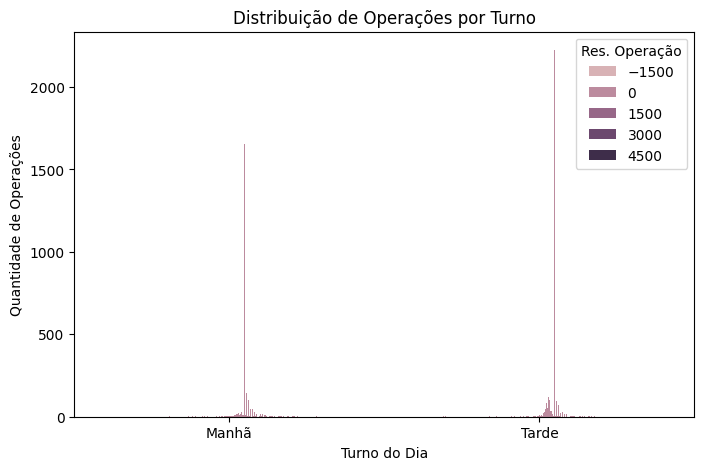

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

df_real['tipo'] = 'Real'
df_simula['tipo'] = 'Simulada'

df_comparativo = pd.concat([df_real, df_simula])

plt.figure(figsize=(8,5))
sns.countplot(data=df_comparativo[df_comparativo['turno'] != 'Fora do Horário'], x='turno', hue='Res. Operação')
plt.title('Distribuição de Operações por Turno')
plt.xlabel('Turno do Dia')
plt.ylabel('Quantidade de Operações')
plt.show()

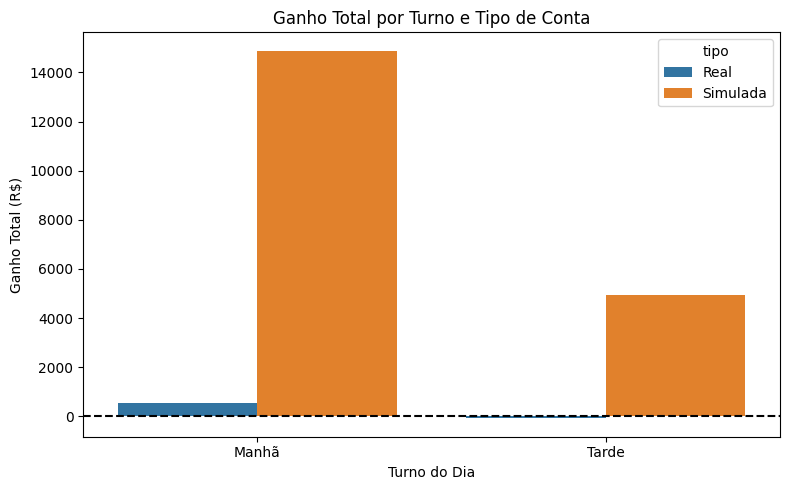

In [93]:
# Verifica se a coluna de resultado financeiro se chama assim:
# Supondo que seja 'Ganho' — ajuste conforme o nome real da sua planilha
df_comparativo['Res. Operação'] = df_comparativo['Res. Operação'].astype(float)

# Agrupar por turno e tipo, somar os ganhos
soma_ganhos = df_comparativo.groupby(['turno', 'tipo'])['Res. Operação'].sum().reset_index()

# Plotar
plt.figure(figsize=(8,5))
sns.barplot(data=soma_ganhos[soma_ganhos['turno'] != 'Fora do Horário'], x='turno', y='Res. Operação', hue='tipo')
plt.title('Ganho Total por Turno e Tipo de Conta')
plt.xlabel('Turno do Dia')
plt.ylabel('Ganho Total (R$)')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


In [94]:
# Garantir que ambas as colunas 'Abertura' estão em formato datetime
df_real['Abertura'] = pd.to_datetime(df_real['Abertura'])
df_simula['Abertura'] = pd.to_datetime(df_simula['Abertura'])

# Extrair apenas a data (sem hora)
datas_reais = df_real['Abertura'].dt.date.unique()

# Filtrar df_simula para manter apenas datas que também estão no real
df_simula_equalizado = df_simula[df_simula['Abertura'].dt.date.isin(datas_reais)].copy()


In [95]:
df_simula_equalizado

,ESTRATEGIA,Ativo,Abertura,Fechamento,Tempo Operação,Qtd Compra,Qtd Venda,Lado,Preço Compra,Preço Venda,...,Número Operação,Res. Operação,Res. Operação (%),TET,Total,Ganho Acumulado,duracao,hora_abertura,turno,tipo
0,OPERACOES_TRADE_V06_HFT_BUY__IND_SIM_TCC_20250...,WING25,2025-01-03 10:17:59,2025-01-03 10:18:05,6s,1,1,C,121215.00,121230.00,...,1,3,15.00,-,3,3,0.100000,10,Fora do Horário,Simulada
1,OPERACOES_TRADE_V06_HFT_BUY__IND_SIM_TCC_20250...,WING25,2025-01-03 10:18:31,2025-01-03 10:18:35,4s,1,1,C,121175.00,121190.00,...,2,3,15.00,31s,6,6,0.066667,10,Fora do Horário,Simulada
2,OPERACOES_TRADE_V06_HFT_BUY__IND_SIM_TCC_20250...,WING25,2025-01-03 10:18:43,2025-01-03 10:18:43,-,1,1,C,121200.00,121215.00,...,3,3,15.00,12s,9,9,0.000000,10,Fora do Horário,Simulada
3,OPERACOES_TRADE_V06_HFT_BUY__IND_SIM_TCC_20250...,WING25,2025-01-03 10:18:52,2025-01-03 10:19:01,9s,2,2,C,121160.00,121175.00,...,4,6,15.00,9s,15,15,0.150000,10,Fora do Horário,Simulada
4,OPERACOES_TRADE_V06_HFT_BUY__IND_SIM_TCC_20250...,WING25,2025-01-03 10:19:39,2025-01-03 10:19:52,13s,1,1,C,121185.00,121200.00,...,5,3,15.00,46s,18,18,0.216667,10,Fora do Horário,Simulada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9020,OPERACOES_TRADE_V06_HFT_SELL_SIM_TCC_202501_20...,WINJ25,2025-03-28 17:13:20,2025-03-28 17:16:10,2min49s,5,5,V,132618.00,132633.00,...,3049,15,15.00,18s,15274,70507,2.833333,17,Tarde,Simulada
9021,OPERACOES_TRADE_V06_HFT_SELL_SIM_TCC_202501_20...,WINJ25,2025-03-28 17:16:30,2025-03-28 17:16:36,5s,1,1,V,132580.00,132595.00,...,3050,3,15.00,3min10s,15277,70510,0.100000,17,Tarde,Simulada
9022,OPERACOES_TRADE_V06_HFT_SELL_SIM_TCC_202501_20...,WINJ25,2025-03-28 17:18:54,2025-03-28 17:18:56,2s,1,1,V,132560.00,132575.00,...,3051,3,15.00,2min23s,15280,70513,0.033333,17,Tarde,Simulada
9023,OPERACOES_TRADE_V06_HFT_SELL_SIM_TCC_202501_20...,WINJ25,2025-03-28 17:19:00,2025-03-28 17:55:00,36min,54,54,V,132644.26,132652.50,...,3052,89,8.24,5s,15369,70602,36.000000,17,Tarde,Simulada


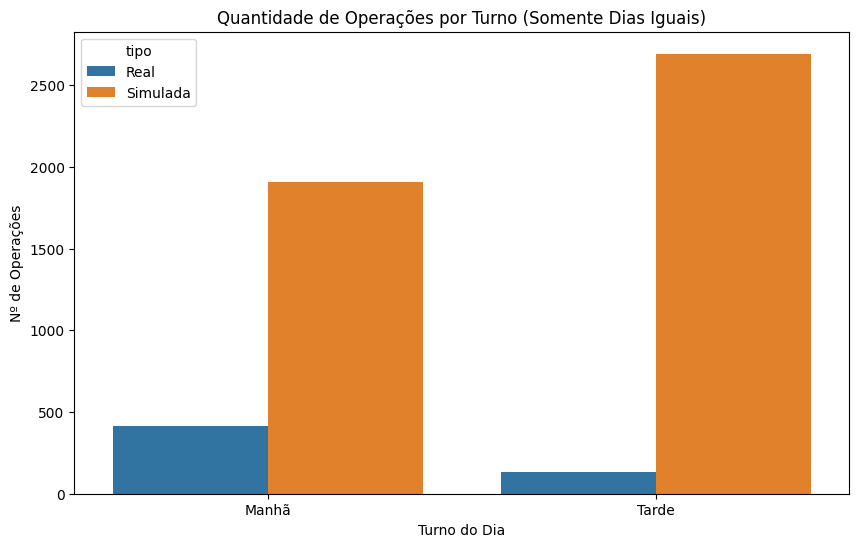

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Atualizar o tipo antes de unir
df_real['tipo'] = 'Real'
df_simula_equalizado['tipo'] = 'Simulada'

# Concatenar os dois DataFrames
df_comparado = pd.concat([df_real, df_simula_equalizado])

# Remover horários fora do padrão (opcional)
df_comparado = df_comparado[df_comparado['turno'] != 'Fora do Horário']

# Plotar
plt.figure(figsize=(10, 6))
sns.countplot(data=df_comparado, x='turno', hue='tipo')
plt.title('Quantidade de Operações por Turno (Somente Dias Iguais)')
plt.xlabel('Turno do Dia')
plt.ylabel('Nº de Operações')
plt.show()


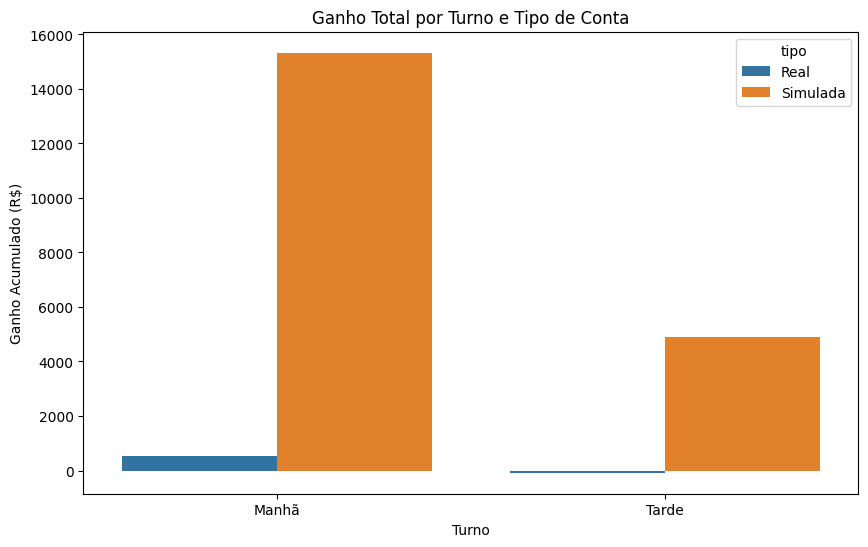

In [100]:
ganhos_turno = df_comparado.groupby(['tipo', 'turno'])['Res. Operação'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=ganhos_turno, x='turno', y='Res. Operação', hue='tipo')
plt.title('Ganho Total por Turno e Tipo de Conta')
plt.xlabel('Turno')
plt.ylabel('Ganho Acumulado (R$)')
plt.show()


In [98]:
# Contar acertos por turno e tipo
acertos = df_comparado.groupby(['tipo', 'turno'])['Res. Operação'].value_counts().unstack().fillna(0)

# Calcular taxa de acerto
acertos['Taxa_Acerto_%'] = (acertos.get('Gain', 0) / (acertos.get('Gain', 0) + acertos.get('Loss', 0))) * 100
acertos = acertos.reset_index()

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(data=acertos, x='turno', y='Taxa_Acerto_%', hue='tipo')
plt.title('Taxa de Acerto por Turno')
plt.ylabel('Taxa de Acerto (%)')
plt.xlabel('Turno')
plt.ylim(0, 100)
plt.show()


KeyError: 'Column not found: Res. Operacao'